In [1]:
import os
import subprocess
import shutil
import copy
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import geopandas as gpd
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridintersect import GridIntersect
from lumpyrem import run
import pyemu

from shapely.geometry import Polygon, LineString, Point
import shapefile
from shapely.prepared import prep

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 14})

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

In [3]:
org_model_ws = os.path.join('..', 'temp_flopy_lumprem')
#os.listdir(org_model_ws)

**Setup directory structure**:

In [4]:
model_root = os.path.join('..', 'temp_ml_param')

runmodel_ws = os.path.join(model_root, 'runmodel')
model_ws = os.path.join(runmodel_ws, 'model')
preproc_ws = os.path.join(runmodel_ws, 'preproc')
lumprem_ws = os.path.join(runmodel_ws, 'lumprem')

pest_ws = os.path.join(model_root, 'pest')
template_ws = os.path.join(pest_ws, 'template')
instruction_ws = os.path.join(pest_ws, 'instruction')

In [5]:
dir_lvl1 = [runmodel_ws, pest_ws]
dir_lvl2 = [model_ws, preproc_ws, lumprem_ws, template_ws, instruction_ws]

In [6]:
if os.path.exists(model_root):
    shutil.rmtree(model_root)

os.mkdir(model_root)

In [7]:
for pth in dir_lvl1:
    os.mkdir(pth)
for pth in dir_lvl2:
    os.mkdir(pth)

In [8]:
shutil.copytree(org_model_ws,model_ws, dirs_exist_ok=True)
#os.listdir(model_ws)

'..\\temp_ml_param\\runmodel\\model'

Move all the LUMPREM template files to `template_ws` and SEGLIST files to `preproc_ws` directories:

In [9]:
def move_files(old_pth, new_pth, file):
    from_ = os.path.join(old_pth, file)
    to_ = os.path.join(new_pth, file)
    shutil.move(from_, to_)

In [10]:
lr_tpls = [i for i in os.listdir(model_ws) if '.tpl' in i]

In [11]:
for file in lr_tpls:
    move_files(model_ws, template_ws, file)

In [12]:
move_files(model_ws, preproc_ws, 'sfr_segfile.dat')
move_files(model_ws, preproc_ws, 'pps_ghb.dat')

Move all the LUMPREM input files to `lumprem_ws`:

In [13]:
lr_prep_pth = os.path.join('..', 'temp_lr_prep')
#os.listdir(lr_prep_pth)

In [14]:
for file in os.listdir(lr_prep_pth):
    shutil.copyfile(os.path.join(lr_prep_pth, file), os.path.join(lumprem_ws, file))

In [15]:
#os.listdir(lumprem_ws)

## Begin parameterization

In [16]:
ml_name = 'hagfors_1'

In [17]:
sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package sfr...
    loading package obs...
    loading package ghb...
  loading ims package hagfors_1...


In [18]:
gwf = sim.get_model(ml_name)

## 1. Setup pilot points

### 1.1 Hydraulic conductivity pps
The hydraulic conductivity pilot points have been manually placed in order to optimize between optimal placement locations while keeping the amount of adjustable parameters reasonably low.

In [19]:
kh_gdf = gpd.read_file(os.path.join(shapefile_pth, 'pps_cond.shp'))

In [20]:
kh_gdf.head()

name  zone    kh    kv        POINT_X       POINT_Y  \
0  ppcond     1  86.4  8.64  426900.000000  6.654790e+06   
1  ppcond     1  86.4  8.64  426900.000000  6.654830e+06   
2  ppcond     1  86.4  8.64  426900.000000  6.654870e+06   
3  ppcond     1  86.4  8.64  426900.000000  6.654890e+06   
4  ppcond     1  86.4  8.64  426906.156956  6.654910e+06   

                         geometry  
0  POINT (426900.000 6654790.000)  
1  POINT (426900.000 6654830.000)  
2  POINT (426900.000 6654870.000)  
3  POINT (426900.000 6654890.000)  
4  POINT (426906.157 6654909.938)

In [21]:
# Assign each pp a unique name:
kh_gdf.name = [f'pp{i:03d}' for i in range(1, len(kh_gdf.name)+1)]

# Rename X and Y columns:
kh_gdf.rename(columns={'POINT_X': 'x', 'POINT_Y': 'y'}, inplace=True)

# Rearrange columns to conform with PEST standard and omit redundant column:
kh_gdf = kh_gdf[['name', 'x', 'y', 'zone', 'kh', 'kv']]

kh_gdf.head()

name              x             y  zone    kh    kv
0  pp001  426900.000000  6.654790e+06     1  86.4  8.64
1  pp002  426900.000000  6.654830e+06     1  86.4  8.64
2  pp003  426900.000000  6.654870e+06     1  86.4  8.64
3  pp004  426900.000000  6.654890e+06     1  86.4  8.64
4  pp005  426906.156956  6.654910e+06     1  86.4  8.64

In [22]:
# Import measurement locations
meas_pos = pd.read_csv(os.path.join(observations_pth, 'measurement_positions.csv'))

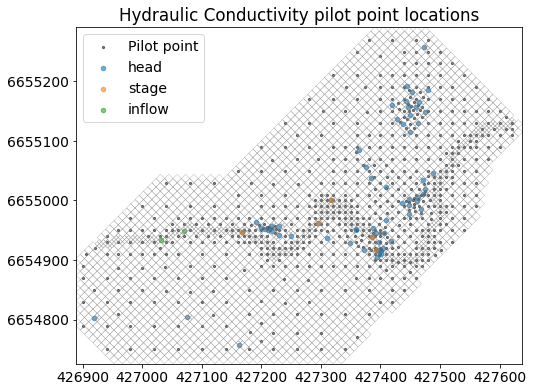

In [23]:
# Visualize results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Hydraulic Conductivity pilot point locations')

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = kh_gdf.x.values
y = kh_gdf.y.values
plt.scatter(x, y, s=5, c='black', alpha=0.5, label='Pilot point')

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=20, alpha=0.6, label=category)
    
plt.legend()
plt.show()

### 1.2 Specific yield and recharge multipliers pps
Pilot points for specific yield and recharge multipliers can be placed more sparse compared with hydraulic conductivity. Because of this, a simple "grid"-style approach (i.e. no manually created shapefile) is applied directly in this notebook.

In [24]:
mlb_shp = shapefile.Reader(os.path.join(shapefile_pth, 'model_boundary.shp')) # Model boundary shapefile
mlb_pts = np.array(np.rint(mlb_shp.shapeRecords()[0].shape.points)) # Coordinate of points defining mlb
mlb_polygon = Polygon(mlb_pts) # Shapely polygon
mlb_shapely_prep = prep(mlb_polygon) # Prepared shapely polygon

In [25]:
xmin, xmax, ymin, ymax = 426900, 427700, 6654650, 6655350 # Model base-grid coordinates
pp_resolution = 33 # Equal space (in meters) between pilot points
pps_initial = [] # List to hold all Sy and RCH mul pps
for lat in np.arange(xmin, xmax, pp_resolution):
    for lon in np.arange(ymin, ymax, pp_resolution):
        pps_initial.append(Point((round(lat,4), round(lon,4))))

In [26]:
pps_pos = [] # Will ONLY contain the pps of pps_initial that are inside of mlb_shapely_prep
for point in pps_initial:
    if mlb_shapely_prep.contains(point):
        pps_pos.append(point)
print(f'Number of points: {len(pps_pos)}')

Number of points: 221


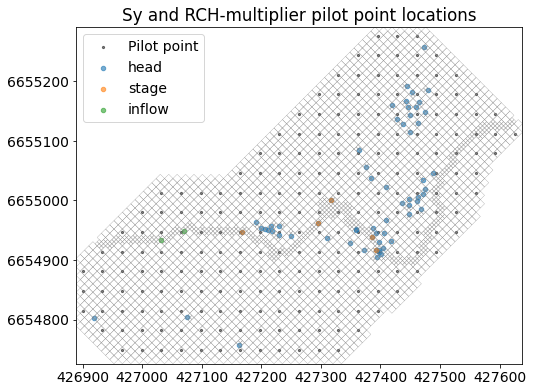

In [27]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Sy and RCH-multiplier pilot point locations')

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = np.array([i.coords[0] for i in pps_pos])[:,0]
y = np.array([i.coords[0] for i in pps_pos])[:,1]
plt.scatter(x, y, s=5, c='black', alpha=0.5, label='Pilot point')

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=20, alpha=0.6, label=category)
    
plt.legend()
plt.show()

In [28]:
# Create a dataframe of the pilot points
pp_sy_rchmul = pd.DataFrame({
    'name': [f'pp{i:03d}' for i in range(1, len(pps_pos) + 1)],
    'x': np.array([i.coords[0] for i in pps_pos])[:,0],
    'y':np.array([i.coords[0] for i in pps_pos])[:,1],
    'zone': 1,
    'sy': 0.25,
    'rchmul': 1.0
})
pp_sy_rchmul.head()

name         x          y  zone    sy  rchmul
0  pp001  426900.0  6654815.0     1  0.25     1.0
1  pp002  426900.0  6654848.0     1  0.25     1.0
2  pp003  426900.0  6654881.0     1  0.25     1.0
3  pp004  426933.0  6654782.0     1  0.25     1.0
4  pp005  426933.0  6654815.0     1  0.25     1.0

### 1.3 Streamflow routing (SFR) pps

In [29]:
sfr_segfile = pd.read_csv(os.path.join(preproc_ws, 'sfr_segfile.dat'), sep='\t', names=['x', 'y', 'seg'])
sfr_segfile.head()

x            y   seg
0  426924.228  6654927.297  r1s1
1  426927.764  6654930.833  r2s1
2  426931.299  6654927.297  r3s1
3  426934.835  6654930.833  r4s1
4  426938.370  6654927.297  r5s1

In [30]:
# Divide the SFR into a suitable amount of segments for purpose of parameterization
nseg = 52
rows_per_seg = int(len(sfr_segfile.seg) / nseg)

In [31]:
for i in range(nseg):
    sfr_segfile.loc[(i * rows_per_seg):((i + 1) * rows_per_seg), ('seg')] = f's{i + 1}'
sfr_segfile.loc[260:, ('seg')] = 's52'

In [32]:
# Rewrite the segfile for use with PLPROC
sfr_segfile.to_csv(os.path.join(preproc_ws, 'sfr_segfile.dat'), header=None, index=False, sep='\t', float_format='%.3f')

In [33]:
# Open csv of initial rbtm and rgrd values
sfr_init_rbth_rgrd = pd.read_csv(os.path.join(model_ws, 'sfr_init_rbtm_rgrd.csv'))

In [34]:
# Create pilot points using every fifth cell / coordinate of the sfr segfile
sfr_pps = sfr_segfile[::5][['x', 'y']].reset_index(drop=True)
sfr_pps[['zone', 'rwid', 'rgrd', 'rbth', 'rhk', 'man']] = '1', 2.0, 0.02, 0.5, 86.4, 0.025
sfr_pps.insert(0, 'name', [i for i in range(1, len(sfr_pps) + 1)])
sfr_pps.head()

name           x            y zone  rwid  rgrd  rbth   rhk    man
0     1  426924.228  6654927.297    1   2.0  0.02   0.5  86.4  0.025
1     2  426941.906  6654930.833    1   2.0  0.02   0.5  86.4  0.025
2     3  426959.584  6654934.368    1   2.0  0.02   0.5  86.4  0.025
3     4  426977.261  6654930.833    1   2.0  0.02   0.5  86.4  0.025
4     5  426994.939  6654934.368    1   2.0  0.02   0.5  86.4  0.025

In [35]:
sfr_pps.rgrd = sfr_init_rbth_rgrd.init_rgrd.values[::-1]
sfr_pps.rbth = sfr_init_rbth_rgrd.init_rbtm.values[::-1]

In [36]:
sfr_pps.head()

name           x            y zone  rwid      rgrd      rbth   rhk    man
0     1  426924.228  6654927.297    1   2.0  0.003014  1.214098  86.4  0.025
1     2  426941.906  6654930.833    1   2.0  0.009431  1.281334  86.4  0.025
2     3  426959.584  6654934.368    1   2.0  0.010212  1.342573  86.4  0.025
3     4  426977.261  6654930.833    1   2.0  0.009739  1.380328  86.4  0.025
4     5  426994.939  6654934.368    1   2.0  0.009691  1.435898  86.4  0.025

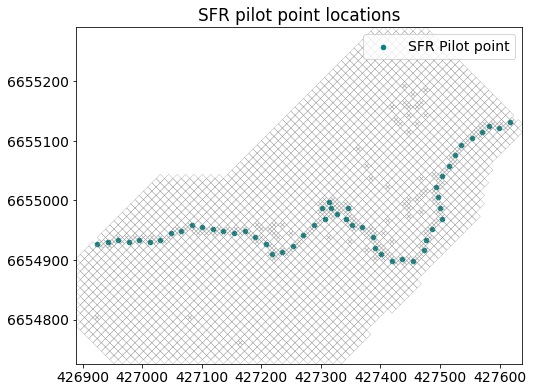

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('SFR pilot point locations')

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = sfr_pps.x.values
y = sfr_pps.y.values
plt.scatter(x, y, s=20, c='teal', label='SFR Pilot point')
    
plt.legend()
plt.show()

### 1.4 General head boundaries (GHB) pps

In [40]:
ghbpp_df = pd.read_csv(os.path.join(preproc_ws, 'pps_ghb.dat'), names=['name', 'x', 'y', 'cond', 'multiplier', 'bnames'], sep='\t')
ghbpp_df[['name', 'zone']] = [f'pp{i:02d}' for i in range(1, len(ghbpp_df) + 1)], 1
ghbpp_df = ghbpp_df[['name','x', 'y', 'zone', 'cond', 'bnames']]

In [41]:
ghbpp_df

name         x          y  zone  cond bnames
0   pp01  427387.0  6655280.0     1  86.4    red
1   pp02  427412.0  6655280.0     1  86.4    red
2   pp03  427438.0  6655280.0     1  86.4    red
3   pp04  427466.0  6655280.0     1  86.4    red
4   pp05  427487.0  6655272.0     1  86.4    red
..   ...       ...        ...   ...   ...    ...
60  pp61  427289.0  6655182.0     1  86.4   blue
61  pp62  427311.0  6655204.0     1  86.4   blue
62  pp63  427334.0  6655227.0     1  86.4   blue
63  pp64  427358.0  6655251.0     1  86.4   blue
64  pp65  427377.0  6655270.0     1  86.4   blue

[65 rows x 6 columns]

In [42]:
ghbpp_df.head()

name         x          y  zone  cond bnames
0  pp01  427387.0  6655280.0     1  86.4    red
1  pp02  427412.0  6655280.0     1  86.4    red
2  pp03  427438.0  6655280.0     1  86.4    red
3  pp04  427466.0  6655280.0     1  86.4    red
4  pp05  427487.0  6655272.0     1  86.4    red

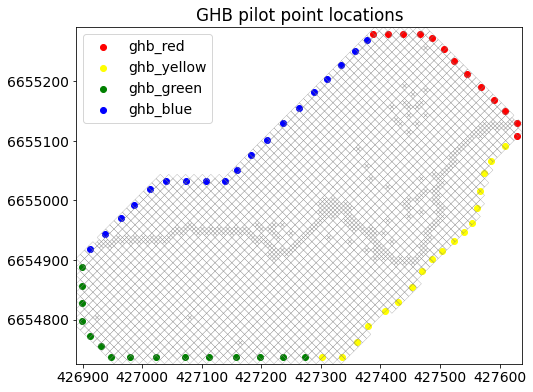

In [43]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('GHB pilot point locations')

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

for bname in ghbpp_df['bnames'].unique():
    df = ghbpp_df.loc[ghbpp_df['bnames'] == bname]
    x = [float(i) for i in df.x.values]
    y = [float(i) for i in df.y.values]
    
    plt.scatter(x, y, color=bname, label=f'ghb_{bname}')

plt.legend()
plt.show()

### 1.5 SFR reach 1 inflow temporal pps

Some form of temporal correlation should exist between inflow values into reach 1. The correlation should not encompass too many parameters, but perhaps 2-3 neighbouring points (the inflow of week x should be influenced by at most the inflow of two weeks backwards and forward: x - 2 | x | x + 2).

In [44]:
# Both perlen and nstp must be changed if the tdis package is altered
perlen = 1492 # Length of the transient stress period
nstp = 1 + 212 # Number of total model timesteps (1 steady state & 212 transient)
sfr_inflow_x, sfr_inflow_y = np.linspace(1, perlen, nstp), np.linspace(0, 0, nstp) # PP temporal coordinates
sfr_inf1_pps = pd.DataFrame({'x': sfr_inflow_x, 'y': sfr_inflow_y, 'zone': 1, 'inflow': 18547})
sfr_inf1_pps.loc[-1] = [0.0, 0.0, '1', 18547]  # adding a row
sfr_inf1_pps.index = sfr_inf1_pps.index + 1  # shifting index
sfr_inf1_pps = sfr_inf1_pps.sort_index()  # sorting by index
sfr_inf1_pps.insert(0, 'name', [f'pp{i:03d}' for i in range(1, len(sfr_inf1_pps) + 1)])
sfr_inf1_pps # x = time (days)

name            x    y zone  inflow
0    pp001     0.000000  0.0    1   18547
1    pp002     1.000000  0.0    1   18547
2    pp003     8.033019  0.0    1   18547
3    pp004    15.066038  0.0    1   18547
4    pp005    22.099057  0.0    1   18547
..     ...          ...  ...  ...     ...
209  pp210  1463.867925  0.0    1   18547
210  pp211  1470.900943  0.0    1   18547
211  pp212  1477.933962  0.0    1   18547
212  pp213  1484.966981  0.0    1   18547
213  pp214  1492.000000  0.0    1   18547

[214 rows x 5 columns]

In [45]:
len(sfr_inf1_pps)

214

## 2. Setup covariance matrices

### 2.1 Hydraulic conductivity

In [46]:
# Save the kh df to a pilot point file
kh_gdf.to_csv(os.path.join(preproc_ws, 'pps_cond.dat'), header=None, index=False, sep='\t')

In [47]:
# Input for MKPPSTAT
npoints = 10
a = 1.2
# run MKPPSTAT
run.run_process('mkppstat', path=preproc_ws, commands=['pps_cond.dat', npoints, a, 'ppstat_cond.dat'])
# run PPCOV_SVA
run.run_process('ppcov_sva', path=preproc_ws, commands=['ppstat_cond.dat', 'y', 1, 'x',  'cov_cond.mat', ''])

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 680 pilot points read from pilot points file pps_cond.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_cond.dat written ok
 

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 680 pilot points read from pilot points file ppstat_cond.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point

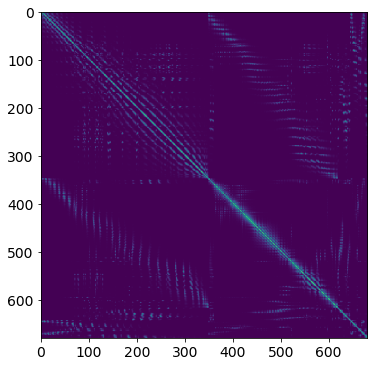

In [48]:
# Inspect the HK covariance matrix
covmat_cond = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_cond.mat'))
plt.figure(figsize=(6, 6))
plt.imshow(covmat_cond.as_2d)

### 2.2 Specific yield and recharge multipliers

In [49]:
# Save the coupled sy & rch multiplier df to a pilot point file
pp_sy_rchmul.to_csv(os.path.join(preproc_ws, 'pps_sy_rchmul.dat'), header=None, index=False, sep='\t')

In [50]:
# run MKPPSTAT using same npoints and a as used for kh
run.run_process('mkppstat', path=preproc_ws, commands=['pps_sy_rchmul.dat', npoints, a, 'ppstat_sy_rchmul.dat'])
# run PPCOV_SVA
run.run_process('ppcov_sva', path=preproc_ws, commands=['ppstat_sy_rchmul.dat', 'y', 1, 'x',  'cov_sy_rchmul.mat', ''])

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 221 pilot points read from pilot points file pps_sy_rchmul.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_sy_rchmul.dat written ok
 

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 221 pilot points read from pilot points file ppstat_sy_rchmul.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  En

In [51]:
# Inspect the coupled Sy & RCH multiplier covariance matrix
covmat_sy_rchmul = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_sy_rchmul.mat'))

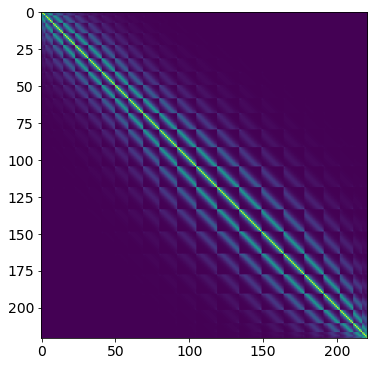

In [52]:
plt.figure(figsize=(6, 6))
plt.imshow(covmat_sy_rchmul.as_2d)

### 2.3 Streamflow routing (SFR)

In [53]:
# Save the sfr-pps df to a pilot point file
sfr_pps.to_csv(os.path.join(preproc_ws, 'pps_sfr.dat'), header=None, index=False, sep='\t', float_format='%.3f')

In [54]:
# run MKPPSTAT using same npoints and a as used for kh
run.run_process('mkppstat', path=preproc_ws, commands=['pps_sfr.dat', npoints, a, 'ppstat_sfr.dat'])
# run PPCOV_SVA - pilot point covariance - spatially varying anisotropy
run.run_process('ppcov_sva', path=preproc_ws, commands=['ppstat_sfr.dat', 'y', 0, 'x',  'cov_sfr.mat', ''])

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 53 pilot points read from pilot points file pps_sfr.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_sfr.dat written ok
 

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 53 pilot points read from pilot points file ppstat_sfr.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point pref

In [55]:
# Inspect the SFR pps covariance matrix
covmat_sfr = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_sfr.mat'))

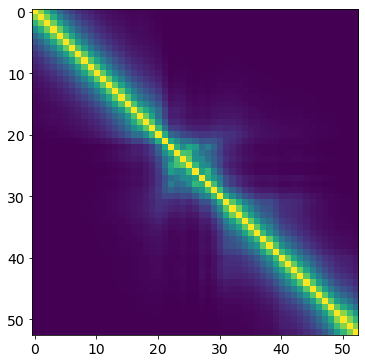

In [56]:
plt.figure(figsize=(6, 6))
plt.imshow(covmat_sfr.as_2d)

### 2.4 General head boundaries (GHB)

In [57]:
# Overwrite the ghb-pps df to a new pilot point file
ghbpp_df.to_csv(os.path.join(preproc_ws, 'pps_ghb.dat'), header=None, index=False, sep='\t')

In [58]:
# Create one pp derivative of each ghb boundname
for bname in ghbpp_df.bnames.unique():
    ghbpp_df.loc[ghbpp_df['bnames'] == bname].to_csv(
        os.path.join(preproc_ws, f'pps_ghb_{bname}.dat'),
        index=False,
        header=False,
        sep='\t',
    )

In [59]:
# Run mkppstat for all GHBs
for file in os.listdir(preproc_ws):
    if 'pps_ghb_' in file:
        run.run_process(
            'mkppstat',
            path=preproc_ws,
            commands=[file, npoints, a, f'ppstat_{file[4:-4]}.dat']
        )

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 19 pilot points read from pilot points file pps_ghb_blue.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_ghb_blue.dat written ok
 

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 15 pilot points read from pilot points file pps_ghb_green.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_ghb_green.dat writte

In [60]:
# Run ppcov_sva for all GHBs
for file in os.listdir(preproc_ws):
    if 'ppstat_ghb' in file:
        filename = f'cov_{file[7:-4]}.mat'
        run.run_process(
            'ppcov_sva',
            path=preproc_ws,
            commands=[file, 'y', 1, 'x',  filename, '']
        )

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 19 pilot points read from pilot points file ppstat_ghb_blue.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter name (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov_ghb_blue.mat written ok.

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 15 pilot points read from pilot points file ppstat_ghb_green.da

In [61]:
# Inspect the GHB pps covariance matrices
covmat_ghb_red = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_ghb_red.mat'))
covmat_ghb_yellow = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_ghb_yellow.mat'))
covmat_ghb_green = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_ghb_green.mat'))
covmat_ghb_blue = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_ghb_blue.mat'))

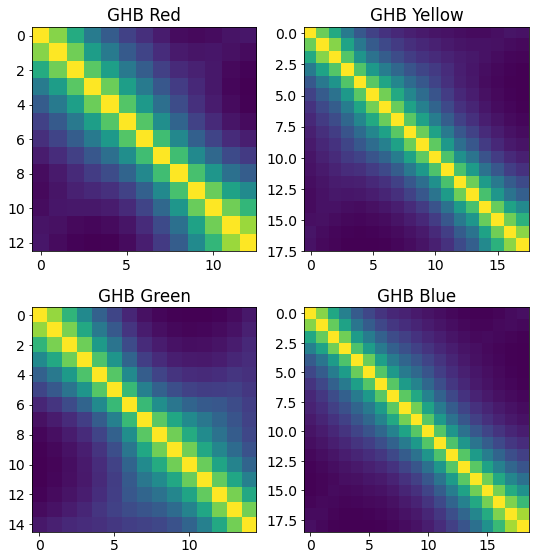

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].set_title('GHB Red')
axs[0, 0].imshow(covmat_ghb_red.as_2d)
axs[0, 1].set_title('GHB Yellow')
axs[0, 1].imshow(covmat_ghb_yellow.as_2d)
axs[1, 0].set_title('GHB Green')
axs[1, 0].imshow(covmat_ghb_green.as_2d)
axs[1, 1].set_title('GHB Blue')
axs[1, 1].imshow(covmat_ghb_blue.as_2d)

plt.tight_layout()
plt.show()

### 2.5 SFR reach 1 inflow

In [63]:
# Save the sfr-pps df to a pilot point file
sfr_inf1_pps.to_csv(os.path.join(preproc_ws, 'pps_sfr_inf1.dat'), header=None, index=False, sep='\t', float_format='%.3f')

In [64]:
# run MKPPSTAT using same npoints and a as used for kh
npoints_sfr1inf = 10 # Use less points for this one
run.run_process('mkppstat', path=preproc_ws, commands=['pps_sfr_inf1.dat', npoints_sfr1inf, a, 'ppstat_sfr_inf1.dat'])
# run PPCOV_SVA - pilot point covariance - spatially varying anisotropy
run.run_process('ppcov_sva', path=preproc_ws, commands=['ppstat_sfr_inf1.dat', 'y', 0, 'x',  'cov_sfr_inf1.mat', ''])

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 214 pilot points read from pilot points file pps_sfr_inf1.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat_sfr_inf1.dat written ok
 

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 214 pilot points read from pilot points file ppstat_sfr_inf1.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter

In [65]:
# Inspect the SFR reach 1 inflow pps covariance matrix
covmat_sfr_inf1 = pyemu.Cov.from_ascii(os.path.join(preproc_ws, 'cov_sfr_inf1.mat'))

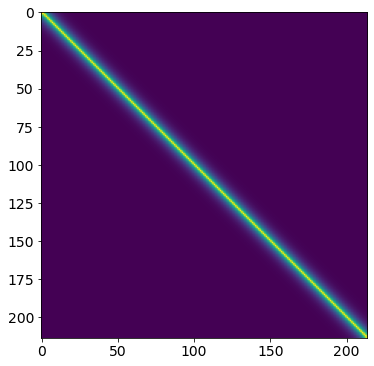

In [66]:
plt.figure(figsize=(6, 6))
plt.imshow(covmat_sfr_inf1.as_2d)

In [67]:
covmat_sfr_inf1.to_dataframe().head()

pp001     pp002     pp003     pp004     pp005     pp006     pp007  \
pp001  1.000000  0.974093  0.779152  0.583548  0.419494  0.305909  0.239698   
pp002  0.974093  1.000000  0.803736  0.604788  0.436313  0.318603  0.249355   
pp003  0.779152  0.803736  1.000000  0.777681  0.575261  0.424070  0.329196   
pp004  0.583548  0.604788  0.777681  1.000000  0.758460  0.564449  0.434601   
pp005  0.419494  0.436313  0.575261  0.758460  1.000000  0.751298  0.573756   

          pp008     pp009     pp010  ...         pp205         pp206  \
pp001  0.181563  0.137528  0.104173  ... -2.212569e-16 -3.846479e-16   
pp002  0.188878  0.143069  0.108370  ...  3.864900e-16  1.309066e-16   
pp003  0.249355  0.188878  0.143069  ...  3.445731e-16  7.282633e-17   
pp004  0.329196  0.249355  0.188878  ... -1.319699e-16 -5.352280e-16   
pp005  0.434601  0.329196  0.249355  ...  3.710307e-16  4.791572e-17   

              pp207         pp208         pp209         pp210         pp211  \
pp001 -2.578345e-16  1.444774e-16 -7.559645e-17  1.723373e-16  1.438856e-16   
pp002  9.139722e-17  3.207231e-16  7.145964e-17  2.477139e-16 -1.118166e-16   
pp003  1.302923e-16  7.691712e-16  4.144398e-16  5.701135e-16  5.627812e-16   
pp004 -2.651862e-16 -1.579429e-16 -4.498209e-16 -1.582983e-16 -2.264000e-16   
pp005  2.401977e-17 -1.689099e-17 -1.937213e-16 -4.972423e-17 -7.986211e-17   

              pp212         pp213         pp214  
pp001 -5.873237e-17  8.437792e-17  1.315765e-16  
pp002 -3.995261e-16 -3.821498e-16 -4.078573e-16  
pp003  4.030902e-16  4.129744e-16  3.631924e-16  
pp004 -4.035977e-16 -3.846113e-16 -4.618464e-16  
pp005 -1.756882e-16  5.841372e-17 -6.088508e-17  

[5 rows x 214 columns]

## 3. Generate PEST template files
This is a bit of "chicken and the egg" problem. Some templates must be generated before PLPROC scripts can be created and some templates have to be generated afterwards.

In [68]:
def prepend_line(filename, line):
    '''
    Function to prepend a line to a textfile, necessary for template files.
    '''
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

In [69]:
# Write generic parameter template for use with PLPROC
with open(os.path.join(template_ws, 'gen_mf_array.tpl'), 'a') as f:
    f.write('$#p prop_mf.write_in_sequence(format="(1x,1pg18.11)")')

### 3.1 Hydraulic conductivity pilot points template

In [70]:
kh_gdf['kh'] = [f'$khpp{i + 1:03d}$' for i,r in kh_gdf.iterrows()]
kh_gdf.to_csv(os.path.join(template_ws, 'pps_cond.tpl'), header=None, index=False, sep='\t')
prepend_line(os.path.join(template_ws, 'pps_cond.tpl'), 'ptf $')

### 3.2 Specific yield and recharge pilot points multiplier template

In [71]:
pp_sy_rchmul['sy'] = [f'$sypp{i + 1:03d}$' for i,r in pp_sy_rchmul.iterrows()]
pp_sy_rchmul['rchmul'] = [f'$rchmulpp{i + 1:03d}$' for i,r in pp_sy_rchmul.iterrows()]
pp_sy_rchmul.to_csv(os.path.join(template_ws, 'pps_sy_rchmul.tpl'), header=None, index=False, sep='\t')
prepend_line(os.path.join(template_ws, 'pps_sy_rchmul.tpl'), 'ptf $')

### 3.3 RCH MODFLOW package template

In [72]:
# This file does not need to have ptf $ prepended
shutil.copyfile(os.path.join(model_ws, f'{ml_name}.rch'), os.path.join(template_ws, f'{ml_name}.rch'))
os.rename(os.path.join(template_ws, f'{ml_name}.rch'), os.path.join(template_ws, f'{ml_name}.rch.tpl'))

### 3.4 Streamflow routing pilot points template

In [73]:
for i in ['rwid', 'rgrd', 'rbth', 'rhk', 'man']:
    sfr_pps[i] = [f'$sfrpp{i}{j:03d}$' for j in range(1, len(sfr_pps) + 1)]
sfr_pps.to_csv(os.path.join(template_ws, 'pps_sfr.tpl'), header=None, index=False, sep='\t', float_format='%.3f')
prepend_line(os.path.join(template_ws, 'pps_sfr.tpl'), 'ptf $')

### 3.5 SFR MODFLOW package template

In [74]:
# This file does not need to have ptf $ prepended
shutil.copyfile(os.path.join(model_ws, f'{ml_name}.sfr'), os.path.join(template_ws, f'{ml_name}.sfr'), )
os.rename(
    os.path.join(template_ws, f'{ml_name}.sfr'),
    os.path.join(template_ws, f'{ml_name}.sfr.tpl')
)

### 3.6 SFR reach 1 inflow template

In [75]:
shutil.copyfile(os.path.join(model_ws, 'sfr_reach1_inflow.ts'), os.path.join(template_ws, 'sfr_reach1_inflow.ts'))
os.rename(os.path.join(template_ws, 'sfr_reach1_inflow.ts'), os.path.join(template_ws, 'sfr_reach1_inflow.tpl'))
prepend_line(os.path.join(template_ws, 'sfr_reach1_inflow.tpl'), 'ptf $')

In [76]:
with open(os.path.join(template_ws, 'sfr_reach1_inflow.tpl'), 'r') as f:
    sfr_r1inf_tsdata = f.readlines()

sfr_r1inf_tsd_start = sfr_r1inf_tsdata.index('BEGIN timeseries\n') + 1
sfr_r1inf_tsd_end = sfr_r1inf_tsdata.index('END timeseries\n')

sfr_inflow_param = [j.replace('18547.00000000', f'$sfrinflow{i:03d}$') for i,j in enumerate(sfr_r1inf_tsdata[sfr_r1inf_tsd_start:sfr_r1inf_tsd_end])]

sfr_r1inf_tsdata[sfr_r1inf_tsd_start:sfr_r1inf_tsd_end] = sfr_inflow_param

with open(os.path.join(template_ws, 'sfr_reach1_inflow.tpl'), 'w') as f:
    for line in sfr_r1inf_tsdata:
        f.write(line)

### 3.7 GHB MODFLOW package template

In [77]:
# This file does not need to have ptf $ prepended
shutil.copyfile(os.path.join(model_ws, f'{ml_name}.ghb'), os.path.join(template_ws, f'{ml_name}.ghb'), )
os.rename(
    os.path.join(template_ws, f'{ml_name}.ghb'),
    os.path.join(template_ws, f'{ml_name}.ghb.tpl')
)

### 3.8 LUMPREM models input file templates

In [78]:
def parameterize_lr_model(lr_template_file, lr_ml_name):
    # Read in the file
    with open(os.path.join(template_ws, lr_template_file), 'r') as f:
        lines = f.readlines()

    # Replace the target string
    lines[4] = f'$ks_{lr_ml_name}$   $m_{lr_ml_name}$   0.5   0.1 \n' #earth properties factors
    lines[41] = f'$crfac_{lr_ml_name}$   $gamma_{lr_ml_name}$  \n' #crop factor & gamma
    
    # If the LUMPREM model is computing elevation for a GHB bhead, parameterize earth properties factors:
    if 'lr_lu1' not in file:
        lines[6] = f'$of_{lr_ml_name}$   $f1_{lr_ml_name}$   $f2_{lr_ml_name}$   $p_{lr_ml_name}$   -9999.0   10000.0\n'
    
    # Write the file out again
    with open(os.path.join(template_ws, lr_template_file), 'w') as f:
        for line in lines:
            f.write(line)

In [79]:
for file in os.listdir(template_ws):
    if 'lr_' in file:
        parameterize_lr_model(file, file[3:][:3])

## 4. Generate PLPROC scripts

In [80]:
def write_script(filename, lines):
    '''
    Function for writing scripts (e.g. PLPROC, OLPROC, TPL2PST, e.t.c.)
    '''
    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [81]:
def replace_in_file(path, input_file, original_str, replacement_str):
    '''
    Function for replacing lines in a textfile.
    Relevant for processing PLPROC scripts and MODFLOW package files.
    '''
    with open(os.path.join(path, input_file), 'r') as f: # Read file
        filedata = f.read()

    filedata = filedata.replace(original_str, replacement_str) # Replace the target string

    with open(os.path.join(path, input_file), 'w') as f: # Overwrite the original file with the new string
        f.write(filedata)

### 4.1 Hydraulic conductivity PLPROC script

In [82]:
write_script(os.path.join(preproc_ws, 'plproc_kh.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb,dimensions=2)

### Read pilot-points file for conductance ###
cl_pp_cond = read_list_file(file=pps_cond.dat,             &
                       id_type=character,                  &
                       dimensions=2,                       &
                       slist=zone; col=4,                  &
                       plist=kh_pp; col=5)

### Calculate kriging factors for conductance clist ###
calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp_cond, file=factors_ppcond.dat)

### Write to template file ###
prop_mf=new_plist(reference_clist=cl_mf,value=86.4)

### Write kh layer 1 ###
prop_mf=kh_pp.krige_using_file(file='factors_ppcond.dat',transform='log')
write_model_input_file(template_file=../../pest/template/gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k.txt)
'''
])

In [83]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_kh.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_kh.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions=2)
> cl_pp_cond=read_list_file(file=pps_cond.dat,id_type=character,dimensi...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp_co...
> prop_mf=new_plist(reference_clist=cl_mf,value=86.4)
> prop_mf=kh_pp.krige_using_file(file='factors_ppcond.dat',transform='l...
> write_model_input_file(template_file=../../pest/template/gen_mf_array...
 
End of file: no more commands to process.



In [84]:
# Comment out kriging factors
replace_in_file(preproc_ws, 'plproc_kh.dat', 'calc_kriging_factors', '#calc_kriging_factors')

### 4.2 Specific yield PLPROC script

In [85]:
write_script(os.path.join(preproc_ws, 'plproc_sy.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb,dimensions=2)

### Read pilot-points file for specific yield ###
cl_pp_sy = read_list_file(file=pps_sy_rchmul.dat,         &
                       id_type=character,                  &
                       dimensions=2,                       &
                       slist=zone; col=4,                  &
                       plist=sy_pp; col=5)

### Calculate kriging factors for each layer ###
calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp_sy, file=factors_ppsy.dat)

### Write to template file ###
prop_mf=new_plist(reference_clist=cl_mf,value=0.25)

###    Write Sy layer 1    ###
prop_mf=sy_pp.krige_using_file(file='factors_ppsy.dat',transform='log')
write_model_input_file(template_file=../../pest/template/gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.sto_sy.txt)
'''
])

In [86]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_sy.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_sy.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions=2)
> cl_pp_sy=read_list_file(file=pps_sy_rchmul.dat,id_type=character,dime...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp_sy...
> prop_mf=new_plist(reference_clist=cl_mf,value=0.25)
> prop_mf=sy_pp.krige_using_file(file='factors_ppsy.dat',transform='log')
> write_model_input_file(template_file=../../pest/template/gen_mf_array...
 
End of file: no more commands to process.



In [87]:
# Comment out kriging factors
replace_in_file(preproc_ws, 'plproc_sy.dat', 'calc_kriging_factors', '#calc_kriging_factors')

### 4.3 Recharge multiplier PLPROC script

In [88]:
write_script(os.path.join(preproc_ws, 'plproc_rchmul.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb,dimensions=2)

### Read pilot-points file for specific yield ###
cl_pp_rchmul = read_list_file(file=pps_sy_rchmul.dat,     &
                       id_type=character,                 &
                       dimensions=2,                      &
                       slist=zone; col=4,                 &
                       plist=rchmul_pp; col=6)

### Calculate kriging factors for each layer ###
calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp_rchmul, file=factors_pprchmul.dat)

### Get Recharge cells ###
rch_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.rch, model_type=undefined;nlay=1;ncpl=3040, &
    list_col_start=1, keytext_start='BEGIN period', keytext_end='END period')

### Write to template file ###
prop_mf=new_plist(reference_clist=cl_mf,value=1.0)

### Write RCH mult layer 1 ###
prop_mf=rchmul_pp.krige_using_file(file='factors_pprchmul.dat',transform='log')

replace_cells_in_lists(old_file=../../pest/template/hagfors_1.rch.tpl,  &
                       new_file=../model/hagfors_1.rch,                 &
                       model_type=undefined;nlay=1;ncpl=3040,           &
                       list_col_start=1,                                &
                       keytext_start='BEGIN period',                    &
                       keytext_end='END period',                        &
                       plist=prop_mf;column=4;action='replace')
'''
])

In [89]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_rchmul.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_rchmul.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions=2)
> cl_pp_rchmul=read_list_file(file=pps_sy_rchmul.dat,id_type=character,...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp_rc...
> rch_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.rch,model...
> prop_mf=new_plist(reference_clist=cl_mf,value=1.0)
> prop_mf=rchmul_pp.krige_using_file(file='factors_pprchmul.dat',transf...
> replace_cells_in_lists(old_file=../../pest/template/hagfors_1.rch.tpl...
 
End of file: no more commands to process.



In [90]:
# Comment out kriging factors
replace_in_file(preproc_ws, 'plproc_rchmul.dat', 'calc_kriging_factors', '#calc_kriging_factors')

### 4.4 Streamflow routing PLPROC script

In [91]:
write_script(os.path.join(preproc_ws, 'plproc_sfr.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb, dimensions=3) # Note 3D in this case

### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)

### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=6.0)

### Instruct PLPROC to read the *.dat list file to obtain parameter values ###
read_list_file(                  &
    reference_clist='cl_sfr_pp', &
    file='pps_sfr.dat',          &
    plist='zone';column=4,       &
    plist='rwid';column=5,       &
    plist='rgrd';column=6,       &
    plist='rbth';column=7,       &
    plist='rhk';column=8,        &
    plist='man';column=9         &
    )

### Instruct PLPROC to build an SLIST of model drain cells to which interpolation must take place ###
sfr_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.sfr, model_type=mf6_disv, &
    list_col_start=2, keytext_start='BEGIN packagedata', keytext_end='END packagedata')

### Calculate interpolation factors to these model cells through linear interpolation ###
calc_linear_interp_factors(source_clist=cl_sfr_pp, target_clist=cl_mf;select=(sfr_cells.ne.0), file="factors_sfr.dat", search_radius=50)

### Write create new parameter lists ###
sfr_rwid=new_plist(reference_clist=cl_mf,value=0.0)
sfr_rgrd=new_plist(reference_clist=cl_mf,value=0.0)
sfr_rbth=new_plist(reference_clist=cl_mf,value=0.0)
sfr_rhk=new_plist(reference_clist=cl_mf,value=0.0)
sfr_man=new_plist(reference_clist=cl_mf,value=0.0)

### Interpolate values ###
sfr_rwid=rwid.interp_using_file(file=factors_sfr.dat, transform=log)
sfr_rgrd=rgrd.interp_using_file(file=factors_sfr.dat, transform=log)
sfr_rbth=rbth.interp_using_file(file=factors_sfr.dat, transform=log)
sfr_rhk=rhk.interp_using_file(file=factors_sfr.dat, transform=log)
sfr_man=man.interp_using_file(file=factors_sfr.dat, transform=log)


### Write values to model ###
replace_cells_in_lists(                                 &
    old_file=../../pest/template/{ml_name}.sfr.tpl,      &
    new_file=../model/{ml_name}.sfr,                    &
    model_type=mf6_disv,                                &
    list_col_start=2,                                   &
    keytext_start='BEGIN packagedata',                  &
    keytext_end='END packagedata',                      &
    plist=sfr_rwid;column=5;action='replace',           &
    plist=sfr_rgrd;column=6;action='replace',           &
    plist=sfr_rbth;column=8;action='replace',           &
    plist=sfr_rhk;column=9;action='replace',            &
    plist=sfr_man;column=10;action='replace'            &
    )

# -- This is for our own interest.
# cl_mf.report_dependent_lists(file='report-sfr.dat')

'''
])

In [92]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_sfr.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_sfr.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions=3)
> sl_sfr=read_segfile(file="sfr_segfile.dat",protocol=table)
> cl_sfr_pp=create_clist_from_seglist(seglist=sl_sfr,linkage_type=endpo...
> read_list_file(reference_clist='cl_sfr_pp',file='pps_sfr.dat',plist='...
> sfr_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.sfr,model...
> calc_linear_interp_factors(source_clist=cl_sfr_pp,target_clist=cl_mf;...
> sfr_rwid=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_rgrd=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_rbth=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_rhk=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_man=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_rwid=rwid.interp_using_file(file=factors_sfr.dat,transform=log)
> sfr_rgrd=rgrd.int

### 4.5 General head boundary PLPROC script

In [93]:
write_script(os.path.join(preproc_ws, 'plproc_ghb.dat'), [
f'''
# -- We read the MODFLOW 6 binary grid file. We read it as a 2D file.

cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb, dimensions=3)

# -- We now build an SLIST of drain cells to which we want interpolation to take place.

ghb_red_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb, model_type=mf6_disv, &
    list_col_start=1, keytext_start='BEGIN period', keytext_end='2768  ghb_yellow')

ghb_yellow_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2776  ghb_red', keytext_end='1  ghb_green')

ghb_green_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb, model_type=mf6_disv, &
    list_col_start=1, keytext_start='3040  ghb_yellow', keytext_end='2  ghb_blue')

ghb_blue_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2902  ghb_green', keytext_end='END period')
    
# -- We next read the pilot points file and pilot point locations and values.

cl_pp = read_list_file(file='pps_ghb.dat',                                        &
                       id_type='character',                                       &
                       dimensions=2,                                              &
                       plist='ghbcond_pp';column=4)

# -- Initialize the drain conductivity PLIST
ghbcond_mf=new_plist(reference_clist=cl_mf,value=0.0)

# -- We now interpolate from pilot points to the conductances.
#    We use inverse power of distance; but any interpolation method could be used.

ghbcond_mf(select=(ghb_red_cells.ne.0))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20) # Perhaps too large?

ghbcond_mf(select=(ghb_yellow_cells.ne.0))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=(ghb_green_cells.ne.0))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=(ghb_blue_cells.ne.0))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

# -- A new model input file is written.

replace_cells_in_lists(old_file=../../pest/template/{ml_name}.ghb.tpl,            &
                       new_file=../model/{ml_name}.ghb,                           &
                       model_type=mf6_disv,                                       &
                       list_col_start=1,                                          &
                       keytext_start='BEGIN period',                              &
                       keytext_end='END period',                                  &
                       plist=ghbcond_mf;column=4;action='replace')

# -- This is for our own interest.
#cl_mf6.report_dependent_lists(file='report-ghb.dat')
'''
])

In [94]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_ghb.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_ghb.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions=3)
> ghb_red_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.ghb,m...
> ghb_yellow_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.gh...
> ghb_green_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.ghb...
> ghb_blue_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.ghb,...
> cl_pp=read_list_file(file='pps_ghb.dat',id_type='character',dimension...
> ghbcond_mf=new_plist(reference_clist=cl_mf,value=0.0)
> ghbcond_mf(select=(ghb_red_cells.ne.0))=ghbcond_pp.ivd_interpolate_2d...
> ghbcond_mf(select=(ghb_yellow_cells.ne.0))=ghbcond_pp.ivd_interpolate...
> ghbcond_mf(select=(ghb_green_cells.ne.0))=ghbcond_pp.ivd_interpolate_...
> ghbcond_mf(select=(ghb_blue_cells.ne.0))=ghbcond_pp.ivd_inte

## 5. Generate custom preprocessing scripts

### 5.1 SFR stream reach top elevation

In [95]:
rtp_init_filename = 'sfr_rtp_initial.csv'
move_files(model_ws, preproc_ws, rtp_init_filename)

In [96]:
rtp_initial = pd.read_csv(os.path.join(preproc_ws, rtp_init_filename))
rtp_model_input_data = rtp_initial -1. # Offset dataset by -1 meter (allow PEST to adjust the parval upwards)
rtp_model_input_data.to_csv(os.path.join(preproc_ws, 'rtp_input.csv'), index=False) # Overwrite the initial file

In [97]:
write_script(os.path.join(preproc_ws, 'sfr_rtpmodel.py'), [
f'''
import os
import pandas as pd
import numpy as np
import math
from scipy.ndimage import gaussian_filter1d

print('Running SFR RTP Model.')

# Set up path and filename references
model_ws = os.path.join('..', 'model')
sfr_file = '{ml_name}.sfr'
rtp_model_input_data = pd.read_csv('rtp_input.csv', names=['rtp'], skiprows=1)

def expand_diff( arr, delta ):
    diff = np.diff( arr, prepend = 0.0 )
    diff[1:] += np.sign( diff[1:] ) * delta
    new_arr = diff.cumsum()
    return new_arr + arr.mean() - new_arr.mean()

# Define model - Parameters to be adjusted by PEST are expansion_coefficient, sigma and offset
def model_rtp(expansion_coefficient, sigma, offset):

    dataset = rtp_model_input_data.rtp.values
    
    temp_rtp = gaussian_filter1d(dataset, sigma) # Apply gaussian filter
    
    temp_rtp = expand_diff(temp_rtp, expansion_coefficient) # Apply expansion coefficient
    
    new_rtp = temp_rtp + offset
    
    return new_rtp

# Replace values in hagfors_1.sfr
# Read MF6 SFR input file
with open(os.path.join(model_ws, 'hagfors_1.sfr'), 'r') as f:
    sfr_file = f.readlines()

# Locate package data section
sfr_pkgdata_strt = sfr_file.index('BEGIN packagedata\\n') + 1
sfr_pkgdata_stop = sfr_file.index('END packagedata\\n')

# Read package data
sfr_pkgdata_df = pd.DataFrame(sfr_file[sfr_pkgdata_strt:sfr_pkgdata_stop])

# Clean up data structure
sfr_pkgdata_df.iloc[:,0] = sfr_pkgdata_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '')
sfr_pkgdata_df[0] = sfr_pkgdata_df[0].str[1:]

# Construct columns
sfr_pkgdata_cols = ['rno', 'lyr', 'icpl', 'rlen', 'rwid', 'rgrd', 'rtp', 'rbth', 'rhk', 'man', 'ncon', 'ustrf', 'ndv', 'bname']

# Insert columns
sfr_pkgdata_df[sfr_pkgdata_cols] = sfr_pkgdata_df[0].str.split(' ', 14, expand=True)

# Remove redundant columns
sfr_pkgdata_df = sfr_pkgdata_df[sfr_pkgdata_cols]

# Replace rtp data with computed output
sfr_pkgdata_df['rtp'] = model_rtp( 0.001, 5.0, 0.5 )

# Create a list with the modeled SFR packagedata entries
sfr_pkgdata_new = []
for i in sfr_pkgdata_df.values.tolist():
    sfr_pkgdata_new.append(' '.join(str(v) for v in i))

# Replace the old packagedata with the new packagedata
sfr_file[sfr_pkgdata_strt:sfr_pkgdata_stop] = sfr_pkgdata_new

# Overwrite model input file
with open(os.path.join(model_ws, 'hagfors_1.sfr'), 'w') as file:
    for line in sfr_file:
        file.write(line)
        
print('SFR RTP Model completed.')
'''
])

#### Create a template of the SFR rtp model

In [98]:
shutil.copyfile(os.path.join(preproc_ws, 'sfr_rtpmodel.py'), os.path.join(template_ws, 'sfr_rtpmodel.py'))
os.rename(os.path.join(template_ws, 'sfr_rtpmodel.py'), os.path.join(template_ws, 'sfr_rtpmodel.tpl'))
prepend_line(os.path.join(template_ws, 'sfr_rtpmodel.tpl'), 'ptf $')

In [99]:
with open(os.path.join(template_ws, 'sfr_rtpmodel.tpl'), 'r') as f:
    sfr_rtp_template = f.readlines()

In [100]:
sfr_rtp_template[60]

"sfr_pkgdata_df['rtp'] = model_rtp( 0.001, 5.0, 0.5 )\n"

In [101]:
sfr_rtp_template[60] = "sfr_pkgdata_df['rtp'] = model_rtp( $sfrrtpexcoef$, $sfrrtpsigma$, $sfrrtpoffset$ )\n"

In [102]:
with open(os.path.join(template_ws, 'sfr_rtpmodel.tpl'), 'w') as f:
    for line in sfr_rtp_template:
        f.write(line)

### 5.2 GHB yellow and GHB blue multipliers

In [103]:
write_script(os.path.join(preproc_ws, 'ghb_multiplier.py'), [
f'''
import os
import numpy as np
import pandas as pd

print('Starting GHB multiplier preprocessing...')

# Set up path and filename references
model_ws = os.path.join('..', 'model')
ghb_file = '{ml_name}.ghb'

with open(os.path.join(model_ws, 'hagfors_1.ghb'), 'r') as file:
    ghb_perdata = file.readlines()

ghb_strt = ghb_perdata.index('BEGIN period  1\\n') + 1
ghb_stop = ghb_perdata.index('END period  1\\n')

ghb_perdata_df = pd.DataFrame(ghb_perdata[ghb_strt:ghb_stop])

ghb_perdata_df.iloc[:,0] = ghb_perdata_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '') # clean up data structure
ghb_perdata_df[0] = ghb_perdata_df[0].str[1:] # seems like it's needed

ghb_perdata_cols = ['lyr', 'icpl', 'bhead', 'cond', 'multiplier', 'boundname']

ghb_perdata_df[ghb_perdata_cols] = ghb_perdata_df[0].str.split(' ', 5, expand=True) # add columns

ghb_perdata_df = ghb_perdata_df[ghb_perdata_cols] # remove redundant column


def apply_ghb_multiplier():
    df = ghb_perdata_df
    
    # Get number of cells in for each of the bounds that we want to parameterize
    len_yellow = len(df.loc[df['bhead'] == 'ghb_yellow']) # Number of cells in yellow GHB cells
    len_blue = len(df.loc[df['bhead'] == 'ghb_blue']) # Number of cells in yellow GHB cells
    
    # PARAMETERS - Suggested parval1: 0.01, parubnd: 0.9, parlbnd:0.001
    
    # Linear interpolation. Suggested parval1: 0.01, parubnd: 0.9, parlbnd:0.001
    yellow_multiplier = np.linspace(1, 0.1, len_yellow)
    blue_multiplier = np.linspace(1, 0.1, len_blue)
    
    # Change data
    df.loc[df['bhead'] == 'ghb_yellow', 'multiplier'] = yellow_multiplier
    df.loc[df['bhead'] == 'ghb_blue', 'multiplier'] = blue_multiplier
    
    return df

ghb_perdata_df_new = apply_ghb_multiplier()

ghb_perdata_df_new['bhead'] = ' ' + ghb_perdata_df_new['bhead'] # Necessary for PLPROC to work
ghb_perdata_df_new['cond'] = ' ' + ghb_perdata_df_new['cond'] # Necessary for PLPROC to work

# Create a list with the modeled GHB perioddata entries
ghb_perdata_new = []
for i in ghb_perdata_df_new.values.tolist():
    ghb_perdata_new.append(' '.join(str(v) for v in i))

# Replace the old perioddata with the new perioddata
ghb_perdata[ghb_strt:ghb_stop] = ghb_perdata_new

# Overwrite model input file
with open(os.path.join(model_ws, 'hagfors_1.ghb'), 'w') as file:
    for line in ghb_perdata:
        file.write(line)

print('GHB multiplier preprocessing completed.')
'''
])

#### Create a template of the GHB multiplier model

In [104]:
shutil.copyfile(os.path.join(preproc_ws, 'ghb_multiplier.py'), os.path.join(template_ws, 'ghb_multiplier.py'))
os.rename(os.path.join(template_ws, 'ghb_multiplier.py'), os.path.join(template_ws, 'ghb_multiplier.tpl'))
prepend_line(os.path.join(template_ws, 'ghb_multiplier.tpl'), 'ptf $')

In [105]:
with open(os.path.join(template_ws, 'ghb_multiplier.tpl'), 'r') as f:
    ghb_multiplier_template = f.readlines()

In [106]:
ghb_multiplier_template[40]

'    yellow_multiplier = np.linspace(1, 0.1, len_yellow)\n'

In [107]:
ghb_multiplier_template[40] = '    yellow_multiplier = np.linspace(1, $ghbyellomult$, len_yellow)\n'
ghb_multiplier_template[41] = '    blue_multiplier = np.linspace(1, $ghbbluemult$, len_blue)\n'

In [108]:
with open(os.path.join(template_ws, 'ghb_multiplier.tpl'), 'w') as file:
    for line in ghb_multiplier_template:
        file.write(line)

### 5.3 SFR reach rainfall and evaporation multipliers

In [109]:
write_script(os.path.join(preproc_ws, 'sfr_rainf_evapo_multiplier.py'), [
f'''
import os
import numpy as np
import pandas as pd

print('Starting SFR reach rainfall and evaporation multiplier preprocessing...')

# Set up path and filename references
model_ws = os.path.join('..', 'model')
rainfall_ts = 'sfr_reach_rainfall.ts'
evaporation_ts = 'sfr_reach_evaporation.ts'

def ts_multiplier(ts_filename, multiplier):
    
    with open(os.path.join(model_ws, ts_filename), 'r') as f:
        tsdata = f.readlines()
    
    strt = tsdata.index('BEGIN TIMESERIES\\n') + 1
    stop = tsdata.index('END TIMESERIES\\n')
    
    tsdata_df = pd.DataFrame([i.split() for i in tsdata[strt:stop]], columns=['time', 'value'])
    
    tsdata_df['value'] = tsdata_df['value'].astype(float) * multiplier
    
    tsdata_df['value'] = tsdata_df['value'].astype(str) + '\\n'
    
    tsdata_new = []
    for i in tsdata_df.values.tolist():
        tsdata_new.append(' '.join(str(v) for v in i))

    # Replace the old tsdata with the new tsdata
    tsdata[strt:stop] = tsdata_new
    
    # Overwrite model input file
    with open(os.path.join(model_ws, ts_filename), 'w') as f:
        for line in tsdata:
            f.write(line)

ts_multiplier(rainfall_ts, 1)
ts_multiplier(evaporation_ts, 1)

print('SFR reach rainfall and evaporation multiplier preprocessing completed.')
'''
])

#### Create a template of the GHB multiplier model

In [110]:
shutil.copyfile(os.path.join(preproc_ws, 'sfr_rainf_evapo_multiplier.py'), os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.py'))
os.rename(os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.py'), os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.tpl'))
prepend_line(os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.tpl'), 'ptf $')

In [111]:
with open(os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.tpl'), 'r') as f:
    sfr_multiplier_template = f.readlines()

In [112]:
sfr_multiplier_template[39]

'ts_multiplier(rainfall_ts, 1)\n'

In [113]:
sfr_multiplier_template[39] = 'ts_multiplier(rainfall_ts, $sfr_rf_mul$)\n'
sfr_multiplier_template[40] = 'ts_multiplier(rainfall_ts, $sfr_ev_mul$)\n'

In [114]:
with open(os.path.join(template_ws, 'sfr_rainf_evapo_multiplier.tpl'), 'w') as file:
    for line in sfr_multiplier_template:
        file.write(line)

## 6. Build partial PEST control file using TPL2PST

In [115]:
write_script(os.path.join(template_ws, 'tpl2pst.in'), [
f'''
# Kh pilot points
start template_file
  template_file     = pps_cond.tpl
  model_input_file  = pps_cond.dat
  transform         = log
  value             = 86.4
  lower_bound       = 0.00001
  upper_bound       = 10000.0
  pargroup          = khpp
end template_file

# Sy and Recharge multiplier pilot points
start template_file
  template_file     = pps_sy_rchmul.tpl
  model_input_file  = pps_sy_rchmul.dat
  transform         = log
  value             = 0.25
  lower_bound       = 0.01
  upper_bound       = 0.4
  pargroup          = changethis
end template_file

# SFR pilot points
start template_file
  template_file     = pps_sfr.tpl
  model_input_file  = pps_sfr.dat
  transform         = log
  value             = 1.0
  lower_bound       = 0.1
  upper_bound       = 10.0
  pargroup          = changethis
end template_file

start template_file
  template_file     = pps_ghb.tpl
  model_input_file  = pps_ghb.dat
  transform         = log
  value             = 86.4
  lower_bound       = 0.00001
  upper_bound       = 10000.0
  pargroup          = ghbppc
end template_file

start template_file
  template_file     = ghb_multiplier.tpl
  model_input_file  = ghb_multiplier.py
  transform         = log
  value             = 0.01
  lower_bound       = 0.001
  upper_bound       = 1.0
  pargroup          = ghbmul
end template_file

start template_file
  template_file     = sfr_rainf_evapo_multiplier.tpl
  model_input_file  = sfr_rainf_evapo_multiplier.py
  transform         = log
  value             = 1.0
  lower_bound       = 0.1
  upper_bound       = 10.0
  pargroup          = sr1mul
end template_file

start template_file
  template_file     = sfr_rtpmodel.tpl
  model_input_file  = sfr_rtpmodel.py
  transform         = log
  value             = 1.0
  lower_bound       = 0.1
  upper_bound       = 10.0
  pargroup          = changethis
end template_file

start template_file
  template_file     = sfr_reach1_inflow.tpl
  model_input_file  = sfr_reach1_inflow.ts
  transform         = log
  value             = 18547
  lower_bound       = 3000     
  upper_bound       = 110000
  pargroup          = sfrinf
end template_file

start template_file
  template_file     = lr_lu1.tpl
  model_input_file  = lr_lu1.in
  transform         = log
  value             = 1
  lower_bound       = 0.1
  upper_bound       = 10
  pargroup          = changethis
end template_file

start template_file
  template_file     = lr_red.tpl
  model_input_file  = lr_red.in
  transform         = log
  value             = 1
  lower_bound       = 0.1   
  upper_bound       = 10
  pargroup          = changethis
end template_file

start template_file
  template_file     = lr_yellow.tpl
  model_input_file  = lr_yellow.in
  transform         = log
  value             = 1
  lower_bound       = 0.1    
  upper_bound       = 10
  pargroup          = changethis
end template_file

start template_file
  template_file     = lr_green.tpl
  model_input_file  = lr_green.in
  transform         = log
  value             = 1
  lower_bound       = 0.1  
  upper_bound       = 10
  pargroup          = changethis
end template_file

start template_file
  template_file     = lr_blue.tpl
  model_input_file  = lr_blue.in
  transform         = log
  value             = 1
  lower_bound       = 0.1    
  upper_bound       = 10
  pargroup          = changethis
end template_file

# Template files not needed in this script due to the
# "replace in file" function of PLPROC are:
# hagfors_1.ghb.tpl, hagfors_1.rch.tpl and hagfors_1.sfr.tpl
'''
])

In [116]:
p = subprocess.run(['tpl2pst', 'tpl2pst.in', 'param.pst'], cwd=template_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TPL2PST Version 17.3. Watermark Numerical Computing.
 - file tpl2pst.in read ok.

 - reading file pps_cond.tpl...
 - 680 params found in file pps_cond.tpl.

 - reading file pps_sy_rchmul.tpl...
 - 442 params found in file pps_sy_rchmul.tpl.

 - reading file pps_sfr.tpl...
 - 265 params found in file pps_sfr.tpl.

 - reading file pps_ghb.tpl...
 - 65 params found in file pps_ghb.tpl.

 - reading file ghb_multiplier.tpl...
 - 2 params found in file ghb_multiplier.tpl.

 - reading file sfr_rainf_evapo_multiplier.tpl...
 - 2 params found in file sfr_rainf_evapo_multiplier.tpl.

 - reading file sfr_rtpmodel.tpl...
 - 3 params found in file sfr_rtpmodel.tpl.

 - reading file sfr_reach1_inflow.tpl...
 - 214 params found in file sfr_reach1_inflow.tpl.

 - reading file lr_lu1.tpl...
 - 4 params found in file lr_lu1.tpl.

 - reading file lr_red.tpl...
 - 8 params found in file lr_red.tpl.

 - reading file lr_yellow.tpl...
 - 8 params found in file lr_yellow.tpl.

 - reading file lr_green.tpl..

## 7. Adjust PEST-file parameter names and groups

Read pestfile:

In [117]:
with open(os.path.join(template_ws, 'param.pst'), 'r') as f:
    pstfile = f.readlines()

pardata_strt = pstfile.index('* parameter data\n') + 1
pardata_stop = pstfile.index('* observation groups\n')

In [118]:
pardata_df = pd.DataFrame(
    [i.split() for i in pstfile[pardata_strt:pardata_stop]],
    columns=['PARNME', 'PARTRANS', 'PARCHGLIM', 'PARVAL1', 'PARLBND', 'PARUBND', 'PARGP', 'SCALE', 'OFFSET']
)
pardata_df.head()

PARNME PARTRANS PARCHGLIM   PARVAL1        PARLBND   PARUBND PARGP SCALE  \
0  khpp001      log    factor  86.40000  1.0000000E-05  10000.00  khpp   1.0   
1  khpp002      log    factor  86.40000  1.0000000E-05  10000.00  khpp   1.0   
2  khpp003      log    factor  86.40000  1.0000000E-05  10000.00  khpp   1.0   
3  khpp004      log    factor  86.40000  1.0000000E-05  10000.00  khpp   1.0   
4  khpp005      log    factor  86.40000  1.0000000E-05  10000.00  khpp   1.0   

  OFFSET  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

#### Adjust parameters and parameter groups not automatically setup in the tpl2pst scripts:

### 7.1 Setup Storage parameters
**Parameter: Specific yield (Sy)**

In [119]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sypp'), 'PARGP'] = 'sypp'

### 7.2 Setup Recharge parameters
**Parameter: Recharge multiplier**

In [120]:
pardata_df.loc[pardata_df['PARNME'].str.contains('rchmul'), 'PARGP'] = 'rchmul'
pardata_df.loc[pardata_df['PARNME'].str.contains('rchmul'), 'PARVAL1'] = 1.0
pardata_df.loc[pardata_df['PARNME'].str.contains('rchmul'), 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'].str.contains('rchmul'), 'PARUBND'] = 10.0

In [121]:
pardata_df.loc[pardata_df['PARNME'].str.contains('rchmul')].head()

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
681  rchmulpp001      log    factor       1     0.1      10  rchmul   1.0   
683  rchmulpp002      log    factor       1     0.1      10  rchmul   1.0   
685  rchmulpp003      log    factor       1     0.1      10  rchmul   1.0   
687  rchmulpp004      log    factor       1     0.1      10  rchmul   1.0   
689  rchmulpp005      log    factor       1     0.1      10  rchmul   1.0   

    OFFSET  
681    0.0  
683    0.0  
685    0.0  
687    0.0  
689    0.0

### 7.3 Setup Streamflow routing (SFR) parameters
| parameter | initial value | upper bound | lower bound |
| --------- |--------------:|-------------| ------------|
| rwid      | 2.0           | 5.0         | 1.0         |
| rgrd      | 0.02          | 0.1         | 0.0005      |
| rbth      | 0.5           | 1.5         | 0.05        |
| rhk       | 86.4          | 8640.0      | 0.0000864   |
| man       | 0.025         | 0.04        | 0.015       |

A rule should enforce that `rwid` is at least 4 times `rbth`.

**Parameter: SFR stream reach width (rwid)**.

In [122]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprwid'), 'PARGP'] = 'sfrwid'
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprwid'), 'PARVAL1'] = 2.0
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprwid'), 'PARLBND'] = 0.5
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprwid'), 'PARUBND'] = 6.0

In [123]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprwid')].head()

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1122  sfrpprwid001      log    factor       2     0.5       6  sfrwid   1.0   
1127  sfrpprwid002      log    factor       2     0.5       6  sfrwid   1.0   
1132  sfrpprwid003      log    factor       2     0.5       6  sfrwid   1.0   
1137  sfrpprwid004      log    factor       2     0.5       6  sfrwid   1.0   
1142  sfrpprwid005      log    factor       2     0.5       6  sfrwid   1.0   

     OFFSET  
1122    0.0  
1127    0.0  
1132    0.0  
1137    0.0  
1142    0.0

**Parameter: SFR stream gradient (rgrd)**.

In [124]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprgrd'), 'PARGP'] = 'sfrgrd'
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprgrd'), 'PARVAL1'] = [round(i,5) for i in sfr_init_rbth_rgrd.init_rgrd[::-1]]
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprgrd'), 'PARLBND'] = 0.0005
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprgrd'), 'PARUBND'] = 0.3

In [125]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprgrd')].head()

PARNME PARTRANS PARCHGLIM  PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1123  sfrpprgrd001      log    factor  0.00301  0.0005     0.3  sfrgrd   1.0   
1128  sfrpprgrd002      log    factor  0.00943  0.0005     0.3  sfrgrd   1.0   
1133  sfrpprgrd003      log    factor  0.01021  0.0005     0.3  sfrgrd   1.0   
1138  sfrpprgrd004      log    factor  0.00974  0.0005     0.3  sfrgrd   1.0   
1143  sfrpprgrd005      log    factor  0.00969  0.0005     0.3  sfrgrd   1.0   

     OFFSET  
1123    0.0  
1128    0.0  
1133    0.0  
1138    0.0  
1143    0.0

**Parameter: SFR stream reach bottom thickness (rbth)**.

In [126]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprbth'), 'PARGP'] = 'sfrbth'
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprbth'), 'PARVAL1'] = [round(i,2) for i in sfr_init_rbth_rgrd.init_rbtm[::-1]]
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprbth'), 'PARLBND'] = 0.05
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprbth'), 'PARUBND'] = 6.0

In [127]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprbth')].head()

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1124  sfrpprbth001      log    factor    1.21    0.05       6  sfrbth   1.0   
1129  sfrpprbth002      log    factor    1.28    0.05       6  sfrbth   1.0   
1134  sfrpprbth003      log    factor    1.34    0.05       6  sfrbth   1.0   
1139  sfrpprbth004      log    factor    1.38    0.05       6  sfrbth   1.0   
1144  sfrpprbth005      log    factor    1.44    0.05       6  sfrbth   1.0   

     OFFSET  
1124    0.0  
1129    0.0  
1134    0.0  
1139    0.0  
1144    0.0

**Parameter: SFR stream reach hydraulic conductivity (rhk)**.

In [128]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprhk'), 'PARGP'] = 'sfrrhk'
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprhk'), 'PARVAL1'] = 86.4
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprhk'), 'PARLBND'] = 0.0000864
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprhk'), 'PARUBND'] = 8640.0

In [129]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrpprhk')].head()

PARNME PARTRANS PARCHGLIM PARVAL1   PARLBND PARUBND   PARGP SCALE  \
1125  sfrpprhk001      log    factor    86.4  8.64e-05    8640  sfrrhk   1.0   
1130  sfrpprhk002      log    factor    86.4  8.64e-05    8640  sfrrhk   1.0   
1135  sfrpprhk003      log    factor    86.4  8.64e-05    8640  sfrrhk   1.0   
1140  sfrpprhk004      log    factor    86.4  8.64e-05    8640  sfrrhk   1.0   
1145  sfrpprhk005      log    factor    86.4  8.64e-05    8640  sfrrhk   1.0   

     OFFSET  
1125    0.0  
1130    0.0  
1135    0.0  
1140    0.0  
1145    0.0

**Parameter: SFR stream reach Manning's coefficient (man)**.

In [130]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrppman'), 'PARGP'] = 'sfrman'
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrppman'), 'PARVAL1'] = 0.02
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrppman'), 'PARLBND'] = 0.015
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrppman'), 'PARUBND'] = 0.04

In [131]:
pardata_df.loc[pardata_df['PARNME'].str.contains('sfrppman')].head()

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1126  sfrppman001      log    factor    0.02   0.015    0.04  sfrman   1.0   
1131  sfrppman002      log    factor    0.02   0.015    0.04  sfrman   1.0   
1136  sfrppman003      log    factor    0.02   0.015    0.04  sfrman   1.0   
1141  sfrppman004      log    factor    0.02   0.015    0.04  sfrman   1.0   
1146  sfrppman005      log    factor    0.02   0.015    0.04  sfrman   1.0   

     OFFSET  
1126    0.0  
1131    0.0  
1136    0.0  
1141    0.0  
1146    0.0

**Parameter: SFR streambed top elevation (rtp) expansion coefficient**.

In [132]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpexcoef', 'PARGP'] = 'sfrtpe'
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpexcoef', 'PARVAL1'] = 0.002
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpexcoef', 'PARLBND'] = 0.0001
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpexcoef', 'PARUBND'] = 0.01

In [133]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpexcoef']

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1456  sfrrtpexcoef      log    factor   0.002  0.0001    0.01  sfrtpe   1.0   

     OFFSET  
1456    0.0

**Parameter: SFR streambed top elevation (rtp) offset**.

In [134]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpoffset', 'PARGP'] = 'sfrtpo'
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpoffset', 'PARVAL1'] = 0.5
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpoffset', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpoffset', 'PARUBND'] = 2.0

In [135]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpoffset']

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1458  sfrrtpoffset      log    factor     0.5    0.01       2  sfrtpo   1.0   

     OFFSET  
1458    0.0

**Parameter: SFR streambed top elevation (rtp) sigma**.

In [136]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpsigma', 'PARGP'] = 'sfrtps'
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpsigma', 'PARVAL1'] = 4.2
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpsigma', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpsigma', 'PARUBND'] = 30.0

In [137]:
pardata_df.loc[pardata_df['PARNME'] == 'sfrrtpsigma']

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1457  sfrrtpsigma      log    factor     4.2     0.1      30  sfrtps   1.0   

     OFFSET  
1457    0.0

### 7.4 Setup General head boundary (GHB) parameters

**Parameter: GHB conductances (cond) pilot points.**

PARVAL1, PARLBND and PARUBND are already defined. Only the PARGP needs to be assigned.

In [138]:
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbcred'), 'PARGP'] = 'ghbcre'
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbcyel'), 'PARGP'] = 'ghbcye'
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbcgre'), 'PARGP'] = 'ghbcgr'
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbcblu'), 'PARGP'] = 'ghbcbl'

In [139]:
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbc')]

PARNME PARTRANS PARCHGLIM   PARVAL1        PARLBND   PARUBND  \
1387  ghbcredpp01      log    factor  86.40000  1.0000000E-05  10000.00   
1388  ghbcredpp02      log    factor  86.40000  1.0000000E-05  10000.00   
1389  ghbcredpp03      log    factor  86.40000  1.0000000E-05  10000.00   
1390  ghbcredpp04      log    factor  86.40000  1.0000000E-05  10000.00   
1391  ghbcredpp05      log    factor  86.40000  1.0000000E-05  10000.00   
...           ...      ...       ...       ...            ...       ...   
1447  ghbcblupp15      log    factor  86.40000  1.0000000E-05  10000.00   
1448  ghbcblupp16      log    factor  86.40000  1.0000000E-05  10000.00   
1449  ghbcblupp17      log    factor  86.40000  1.0000000E-05  10000.00   
1450  ghbcblupp18      log    factor  86.40000  1.0000000E-05  10000.00   
1451  ghbcblupp19      log    factor  86.40000  1.0000000E-05  10000.00   

       PARGP SCALE OFFSET  
1387  ghbcre   1.0    0.0  
1388  ghbcre   1.0    0.0  
1389  ghbcre   1.0    0.0  
1390  ghbcre   1.0    0.0  
1391  ghbcre   1.0    0.0  
...      ...   ...    ...  
1447  ghbcbl   1.0    0.0  
1448  ghbcbl   1.0    0.0  
1449  ghbcbl   1.0    0.0  
1450  ghbcbl   1.0    0.0  
1451  ghbcbl   1.0    0.0  

[65 rows x 9 columns]

### 7.5 Setup LUMPREM parameters

Initial parameter values are obtained from a LUMPREM model calibrated against a well in a previous step.

| parameter | initial | upper bound | lower bound |
| --------- |--------:|-------------| ------------|
| Ks        | 153.0   | 1000.0      | 0.001       |
| m         | 0.17    | 2.0         | 0.01        |
| mvol      | 0.54    | 1.0         | 0.35        |
| vol       | 0.268   | 0.35        | 0.01        |
| f         | 2.207   | 10.0        | 0.01        |
| γ         | 2.07    | 100.0       | 0.01        |
| f1        | 1.06    | 50.0        | 1.0         |
| f2        | 0.83    | 100.0       | 0.1         |
| p         | 0.72    | 100.0       | 0.01        |
| a_red     | 140.5   | 142.5       | 138.5       |
| a_yellow  | 139.0   | 142.0       | 136.0       |
| a_green   | 132.6   | 136.0       | 128.0       |
| a_blue    | 136.0   | 140.0       | 132.0       |

#### General LUMPREM parameters
Parameters to be adjusted in all LUMPREM models.

**Parameter: LUMPREM hydraulic conductivity (Ks)**.

In [140]:
pardata_df.loc[pardata_df['PARNME'].str.contains('ks_'), 'PARGP'] = 'lr_ks'
pardata_df.loc[pardata_df['PARNME'].str.contains('ks_'), 'PARVAL1'] = 188.0
pardata_df.loc[pardata_df['PARNME'].str.contains('ks_'), 'PARLBND'] = 1.0
pardata_df.loc[pardata_df['PARNME'].str.contains('ks_'), 'PARUBND'] = 1000.0

In [141]:
pardata_df.loc[pardata_df['PARNME'].str.contains('ks_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND  PARGP SCALE OFFSET
1673  ks_lu1      log    factor     188       1    1000  lr_ks   1.0    0.0
1677  ks_red      log    factor     188       1    1000  lr_ks   1.0    0.0
1685  ks_yel      log    factor     188       1    1000  lr_ks   1.0    0.0
1693  ks_gre      log    factor     188       1    1000  lr_ks   1.0    0.0
1701  ks_blu      log    factor     188       1    1000  lr_ks   1.0    0.0

**Parameter: LUMPREM M-variable (m)**.

In [142]:
pardata_df.loc[pardata_df['PARNME'].str.contains('m_'), 'PARGP'] = 'lr_m'
pardata_df.loc[pardata_df['PARNME'].str.contains('m_'), 'PARVAL1'] = 0.19
pardata_df.loc[pardata_df['PARNME'].str.contains('m_'), 'PARLBND'] = 0.01
pardata_df.loc[pardata_df['PARNME'].str.contains('m_'), 'PARUBND'] = 2.0

In [143]:
pardata_df.loc[pardata_df['PARNME'].str.contains('m_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND PARGP SCALE OFFSET
1674  m_lu1      log    factor    0.19    0.01       2  lr_m   1.0    0.0
1678  m_red      log    factor    0.19    0.01       2  lr_m   1.0    0.0
1686  m_yel      log    factor    0.19    0.01       2  lr_m   1.0    0.0
1694  m_gre      log    factor    0.19    0.01       2  lr_m   1.0    0.0
1702  m_blu      log    factor    0.19    0.01       2  lr_m   1.0    0.0

**Parameter: LUMPREM crop factor (f)**.

In [144]:
pardata_df.loc[pardata_df['PARNME'].str.contains('crfac_'), 'PARGP'] = 'lr_cf'
pardata_df.loc[pardata_df['PARNME'].str.contains('crfac_'), 'PARVAL1'] = 1.11725
pardata_df.loc[pardata_df['PARNME'].str.contains('crfac_'), 'PARLBND'] = 0.01
pardata_df.loc[pardata_df['PARNME'].str.contains('crfac_'), 'PARUBND'] = 10.0

In [145]:
pardata_df.loc[pardata_df['PARNME'].str.contains('crfac_')]

PARNME PARTRANS PARCHGLIM  PARVAL1 PARLBND PARUBND  PARGP SCALE  \
1675  crfac_lu1      log    factor  1.11725    0.01      10  lr_cf   1.0   
1683  crfac_red      log    factor  1.11725    0.01      10  lr_cf   1.0   
1691  crfac_yel      log    factor  1.11725    0.01      10  lr_cf   1.0   
1699  crfac_gre      log    factor  1.11725    0.01      10  lr_cf   1.0   
1707  crfac_blu      log    factor  1.11725    0.01      10  lr_cf   1.0   

     OFFSET  
1675    0.0  
1683    0.0  
1691    0.0  
1699    0.0  
1707    0.0

**Parameter: LUMPREM gamma (γ)**.

In [146]:
pardata_df.loc[pardata_df['PARNME'].str.contains('gamma_'), 'PARGP'] = 'lr_gam'
pardata_df.loc[pardata_df['PARNME'].str.contains('gamma_'), 'PARVAL1'] = 16.8514
pardata_df.loc[pardata_df['PARNME'].str.contains('gamma_'), 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'].str.contains('gamma_'), 'PARUBND'] = 100.0

In [147]:
pardata_df.loc[pardata_df['PARNME'].str.contains('gamma_')]

PARNME PARTRANS PARCHGLIM  PARVAL1 PARLBND PARUBND   PARGP SCALE  \
1676  gamma_lu1      log    factor  16.8514     0.1     100  lr_gam   1.0   
1684  gamma_red      log    factor  16.8514     0.1     100  lr_gam   1.0   
1692  gamma_yel      log    factor  16.8514     0.1     100  lr_gam   1.0   
1700  gamma_gre      log    factor  16.8514     0.1     100  lr_gam   1.0   
1708  gamma_blu      log    factor  16.8514     0.1     100  lr_gam   1.0   

     OFFSET  
1676    0.0  
1684    0.0  
1692    0.0  
1700    0.0  
1708    0.0

**Parameter: LUMPREM max volume (mvol).**

In [148]:
#pardata_df.loc[pardata_df['PARNME'].str.contains('mvol'), 'PARGP'] = 'lr_mvl'
#pardata_df.loc[pardata_df['PARNME'].str.contains('mvol'), 'PARVAL1'] = 0.54
#pardata_df.loc[pardata_df['PARNME'].str.contains('mvol'), 'PARLBND'] = 0.35
#pardata_df.loc[pardata_df['PARNME'].str.contains('mvol'), 'PARUBND'] = 1.0

In [149]:
#pardata_df.loc[pardata_df['PARNME'].str.contains('mvol')]

**Parameter: LUMPREM initial volume (vol).**

In [150]:
#pardata_df.loc[(pardata_df['PARNME'].str.contains('vol')) & (~pardata_df['PARNME'].str.contains('mvol')), 'PARGP'] = 'lr_vol'
#pardata_df.loc[(pardata_df['PARNME'].str.contains('vol')) & (~pardata_df['PARNME'].str.contains('mvol')), 'PARVAL1'] = 0.268
#pardata_df.loc[(pardata_df['PARNME'].str.contains('vol')) & (~pardata_df['PARNME'].str.contains('mvol')), 'PARLBND'] = 0.01
#pardata_df.loc[(pardata_df['PARNME'].str.contains('vol')) & (~pardata_df['PARNME'].str.contains('mvol')), 'PARUBND'] = 0.35

In [151]:
#pardata_df.loc[(pardata_df['PARNME'].str.contains('vol')) & (~pardata_df['PARNME'].str.contains('mvol'))]

### 7.6 LUMPREM GHB bhead parameters

**Parameter: LUMPREM offset (a).**

As suggested in the PEST documentation, it is not ideal to estimate a reference datum. Rather adding a baseline offset (PEST offset, not to be confused with LUMPREM offset) and estimating the parameter improves PEST performance.

In [152]:
pardata_df.loc[pardata_df['PARNME'].str.contains('of_'), 'PARGP'] = 'lr_off' # Set PARGP to Lumprem offset

In [153]:
pardata_df.loc[pardata_df['PARNME'] == 'of_red', 'OFFSET'] = 137.5 # This is the real lower bound
pardata_df.loc[pardata_df['PARNME'] == 'of_red', 'PARVAL1'] = 3.0 # 137.5 + 3.0 = 140.5 m.a.s.l.
pardata_df.loc[pardata_df['PARNME'] == 'of_red', 'PARLBND'] = 0.1 # 137.5 + 0.1 = 137.6 m.a.s.l.
pardata_df.loc[pardata_df['PARNME'] == 'of_red', 'PARUBND'] = 6.5 # 137.5 + 6.5 = 144.0 m.a.s.l.

In [154]:
pardata_df.loc[pardata_df['PARNME'] == 'of_yel', 'OFFSET'] = 136.0 # This is the real lower bound
pardata_df.loc[pardata_df['PARNME'] == 'of_yel', 'PARVAL1'] = 3.0
pardata_df.loc[pardata_df['PARNME'] == 'of_yel', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'] == 'of_yel', 'PARUBND'] = 6.0

In [155]:
pardata_df.loc[pardata_df['PARNME'] == 'of_gre', 'OFFSET'] = 128.0 # This is the real lower bound
pardata_df.loc[pardata_df['PARNME'] == 'of_gre', 'PARVAL1'] = 4.6
pardata_df.loc[pardata_df['PARNME'] == 'of_gre', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'] == 'of_gre', 'PARUBND'] = 8.0

In [156]:
pardata_df.loc[pardata_df['PARNME'] == 'of_blu', 'OFFSET'] = 135.0 # This is the real lower bound
pardata_df.loc[pardata_df['PARNME'] == 'of_blu', 'PARVAL1'] = 1.0
pardata_df.loc[pardata_df['PARNME'] == 'of_blu', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'] == 'of_blu', 'PARUBND'] = 5.0

In [157]:
pardata_df.loc[pardata_df['PARNME'].str.contains('of_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE OFFSET
1679  of_red      log    factor       3     0.1     6.5  lr_off   1.0  137.5
1687  of_yel      log    factor       3     0.1       6  lr_off   1.0    136
1695  of_gre      log    factor     4.6     0.1       8  lr_off   1.0    128
1703  of_blu      log    factor       1     0.1       5  lr_off   1.0    135

**Parameter: LUMPREM factor 1 (f1):**

In [158]:
pardata_df.loc[pardata_df['PARNME'].str.contains('f1_'), 'PARGP'] = 'lr_f1'
pardata_df.loc[pardata_df['PARNME'].str.contains('f1_'), 'PARVAL1'] = 1.18
pardata_df.loc[pardata_df['PARNME'].str.contains('f1_'), 'PARLBND'] = 0.1
pardata_df.loc[pardata_df['PARNME'].str.contains('f1_'), 'PARUBND'] = 50.0

In [159]:
pardata_df.loc[pardata_df['PARNME'].str.contains('f1_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND  PARGP SCALE OFFSET
1680  f1_red      log    factor    1.18     0.1      50  lr_f1   1.0    0.0
1688  f1_yel      log    factor    1.18     0.1      50  lr_f1   1.0    0.0
1696  f1_gre      log    factor    1.18     0.1      50  lr_f1   1.0    0.0
1704  f1_blu      log    factor    1.18     0.1      50  lr_f1   1.0    0.0

**Parameter: LUMPREM factor 2 (f2):**

In [160]:
pardata_df.loc[pardata_df['PARNME'].str.contains('f2_'), 'PARGP'] = 'lr_f2'
pardata_df.loc[pardata_df['PARNME'].str.contains('f2_'), 'PARVAL1'] = 1.03
pardata_df.loc[pardata_df['PARNME'].str.contains('f2_'), 'PARLBND'] = 0.01
pardata_df.loc[pardata_df['PARNME'].str.contains('f2_'), 'PARUBND'] = 100.0

In [161]:
pardata_df.loc[pardata_df['PARNME'].str.contains('f2_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND  PARGP SCALE OFFSET
1681  f2_red      log    factor    1.03    0.01     100  lr_f2   1.0    0.0
1689  f2_yel      log    factor    1.03    0.01     100  lr_f2   1.0    0.0
1697  f2_gre      log    factor    1.03    0.01     100  lr_f2   1.0    0.0
1705  f2_blu      log    factor    1.03    0.01     100  lr_f2   1.0    0.0

**Parameter: LUMPREM power (p):**

In [162]:
pardata_df.loc[pardata_df['PARNME'].str.contains('p_'), 'PARGP'] = 'lr_pow'
pardata_df.loc[pardata_df['PARNME'].str.contains('p_'), 'PARVAL1'] = 1.305
pardata_df.loc[pardata_df['PARNME'].str.contains('p_'), 'PARLBND'] = 0.01
pardata_df.loc[pardata_df['PARNME'].str.contains('p_'), 'PARUBND'] = 100.0

In [163]:
pardata_df.loc[pardata_df['PARNME'].str.contains('p_')]

PARNME PARTRANS PARCHGLIM PARVAL1 PARLBND PARUBND   PARGP SCALE OFFSET
1682  p_red      log    factor   1.305    0.01     100  lr_pow   1.0    0.0
1690  p_yel      log    factor   1.305    0.01     100  lr_pow   1.0    0.0
1698  p_gre      log    factor   1.305    0.01     100  lr_pow   1.0    0.0
1706  p_blu      log    factor   1.305    0.01     100  lr_pow   1.0    0.0

### 7.8 Replace old parameter data

In [164]:
pardata_df.sort_values(['PARGP', 'PARNME'], inplace=True)

In [165]:
pardata_list = pardata_df.values.tolist()

In [166]:
pardata_new = []
for i in pardata_list:
    pardata_new.append(' '.join(str(v) for v in i))
pardata_new = [i + '\n' for i in pardata_new]

Create a temporary copy of the original `pstfilep_param`:

In [167]:
pstfile_temp = pstfile[:]

Replace the old parameter data with the changed pardata in the templist:

In [168]:
for (index, replacement) in zip([i for i in range(pardata_strt, pardata_stop)], pardata_new):
    pstfile_temp[index] = replacement

### 7.9 Change parameter groups

Get relevant indices:

In [169]:
pargrp_start = pstfile_temp.index('* parameter groups\n') + 1
pargrp_stop = pstfile_temp.index('* parameter data\n')

Let's have a look at the current parameter grous config:

In [170]:
pargrp_df = pd.DataFrame(pstfile_temp[pargrp_start:pargrp_stop])
pargrp_df.iloc[:,0] = pargrp_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '')
pargrp_cols = ['PARGPNME', 'INCTYP', 'DERINC', 'DERINCLB', 'FORCEN', 'DERINCMUL', 'DERMTHD']
pargrp_df[pargrp_cols] = pargrp_df[0].str.split(' ', 7, expand=True)
pargrp_df = pargrp_df[pargrp_cols]
display(pargrp_df)

PARGPNME    INCTYP DERINC DERINCLB  FORCEN DERINCMUL      DERMTHD
0        khpp  relative  0.015      0.0  switch         2  parabolic\n
1  changethis  relative  0.015      0.0  switch         2  parabolic\n

Recreate this data structure (no need to use a dataframe):

In [171]:
pargrp_new = [' '.join(str(v) for v in [i, 'relative', 0.015, 0.0, 'switch', 2, 'parabolic\n']) for i in pardata_df['PARGP'].unique()]
display(pargrp_new)

['ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 parabolic\n',
 'lr_pow relative 0.015 0.0 switch 2 parabolic\n',
 'rchmul relative 0.015 0.0 switch 2 parabolic\n',
 'sfrbth relative 0.015 0.0 switch 2 parabolic\n',
 'sfrgrd relative 0.015 0.0 switch 2 parabolic\n',
 'sfrinf relative 0.015 0.0 switch 2 parabolic\n',
 'sfrman relative 0.015 0.0 switch 2 parabolic\n',
 'sfrrhk relative 0.015 0.0 switch 2 pa

Make a new copy of the partial pestfile:

In [172]:
pstfile_new = pstfile_temp[:]

Replace the old parameter groups with the changed pargp in the temp2list:

In [173]:
pstfile_new[pargrp_start:pargrp_stop] = pargrp_new

The parameter groups have now been changed:

In [174]:
display(pstfile_new)

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '      1709         0         6         0         0\n',
 '   13  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0

### Change NPARGP (number of parameter groups)

This is the third column of the third index (number 3 below):

In [175]:
pstfile_new[3]

'      1709         0         6         0         0\n'

In [176]:
temp_row = pstfile_new[3].split()
display(temp_row)

['1709', '0', '6', '0', '0']

In [177]:
npargp = len(pardata_df['PARGP'].unique()) # number of parameter groups
print(npargp)

26


In [178]:
temp_row[2] = str(npargp)
temp_row[-1] = '0\n'
display(temp_row)

['1709', '0', '26', '0', '0\n']

In [179]:
new_row = ' '.join(temp_row)
display(new_row)

'1709 0 26 0 0\n'

In [180]:
pstfile_new[3] = new_row

In [181]:
display(pstfile_new)

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1709 0 26 0 0\n',
 '   13  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 parabolic\n',
 'lr_pow re

### Write new partial pest parameter file:

In [182]:
partial_pestfile = 'calib0.pst'

In [183]:
with open(os.path.join(pest_ws, partial_pestfile), 'w') as f:
    for line in pstfile_new:
        f.write(line)

### Fix model input/output

In [184]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'r') as f:
    pstfile = f.readlines() #pestfile partial parameters

Get index:

In [185]:
ml_io_start = pstfile.index('* model input/output\n') + 1

In [186]:
pstfile[ml_io_start:]

['pps_cond.tpl    pps_cond.dat\n',
 'pps_sy_rchmul.tpl    pps_sy_rchmul.dat\n',
 'pps_sfr.tpl    pps_sfr.dat\n',
 'pps_ghb.tpl    pps_ghb.dat\n',
 'ghb_multiplier.tpl    ghb_multiplier.py\n',
 'sfr_rainf_evapo_multiplier.tpl    sfr_rainf_evapo_multiplier.py\n',
 'sfr_rtpmodel.tpl    sfr_rtpmodel.py\n',
 'sfr_reach1_inflow.tpl    sfr_reach1_inflow.ts\n',
 'lr_lu1.tpl    lr_lu1.in\n',
 'lr_red.tpl    lr_red.in\n',
 'lr_yellow.tpl    lr_yellow.in\n',
 'lr_green.tpl    lr_green.in\n',
 'lr_blue.tpl    lr_blue.in\n']

In [187]:
prepend1, prepend2 = '.\\template\\', '..\\runmodel\\preproc\\'

In [188]:
new_ml_io = []
for i in pstfile[ml_io_start:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io.append(string + j)
new_ml_io = [' '.join(i) for i in zip(new_ml_io[0::2], new_ml_io[1::2])]
new_ml_io = [i+'\n' for i in new_ml_io]
new_ml_io = [i.replace('preproc', 'lumprem') if 'lr' in i else i for i in new_ml_io]
sfr_periodindex_inf = '.\\template\\sfr_reach1_inflow.tpl ..\\runmodel\\preproc\\sfr_reach1_inflow.ts\n'
new_ml_io[new_ml_io.index(sfr_periodindex_inf)] = sfr_periodindex_inf.replace('preproc', 'model')
new_ml_io

['.\\template\\pps_cond.tpl ..\\runmodel\\preproc\\pps_cond.dat\n',
 '.\\template\\pps_sy_rchmul.tpl ..\\runmodel\\preproc\\pps_sy_rchmul.dat\n',
 '.\\template\\pps_sfr.tpl ..\\runmodel\\preproc\\pps_sfr.dat\n',
 '.\\template\\pps_ghb.tpl ..\\runmodel\\preproc\\pps_ghb.dat\n',
 '.\\template\\ghb_multiplier.tpl ..\\runmodel\\preproc\\ghb_multiplier.py\n',
 '.\\template\\sfr_rainf_evapo_multiplier.tpl ..\\runmodel\\preproc\\sfr_rainf_evapo_multiplier.py\n',
 '.\\template\\sfr_rtpmodel.tpl ..\\runmodel\\preproc\\sfr_rtpmodel.py\n',
 '.\\template\\sfr_reach1_inflow.tpl ..\\runmodel\\model\\sfr_reach1_inflow.ts\n',
 '.\\template\\lr_lu1.tpl ..\\runmodel\\lumprem\\lr_lu1.in\n',
 '.\\template\\lr_red.tpl ..\\runmodel\\lumprem\\lr_red.in\n',
 '.\\template\\lr_yellow.tpl ..\\runmodel\\lumprem\\lr_yellow.in\n',
 '.\\template\\lr_green.tpl ..\\runmodel\\lumprem\\lr_green.in\n',
 '.\\template\\lr_blue.tpl ..\\runmodel\\lumprem\\lr_blue.in\n']

In [189]:
pstfile[ml_io_start:] = new_ml_io

Overwrite `calib0.pst`:

In [190]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'w') as f:
    for line in pstfile:
        f.write(line)

In [191]:
# Errors pertaining to NOBS, NOBSGP and NINSFILE are irrelevant.
# They will be adressed in the next notebook.
p = subprocess.run(['i64pestchek', 'calib0.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 Line 4 of file calib0.pst: integer variable NOBS given as zero.
   (Give all observations zero weight to optimize using prior info only.)
 Line 4 of file calib0.pst: integer variable NOBSGP zero or negative.
 Line 5 of file calib0.pst: integer variable NINSFLE zero or negative.



### END OF NOTEBOOK

---